## Food Inspection:  Extracting Data from API

### Creating a grid of points  
There are limits to how many queries I can do with geoapify.  Instead of querying each address of a business and getting one result, I will batch my queries by making a grid of points where I will make a query at each point and get all the businesses for that area.  This will reduce individual searchs from tens of thousands to just a couple hundred queries.  The grid of points will be used in the `geo_feature_dev.ipynb` notebook.  

In [1]:
# Packages
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon  
import csv

[-87.94011408  41.64454312 -87.5241371   42.02303859]


<Axes: >

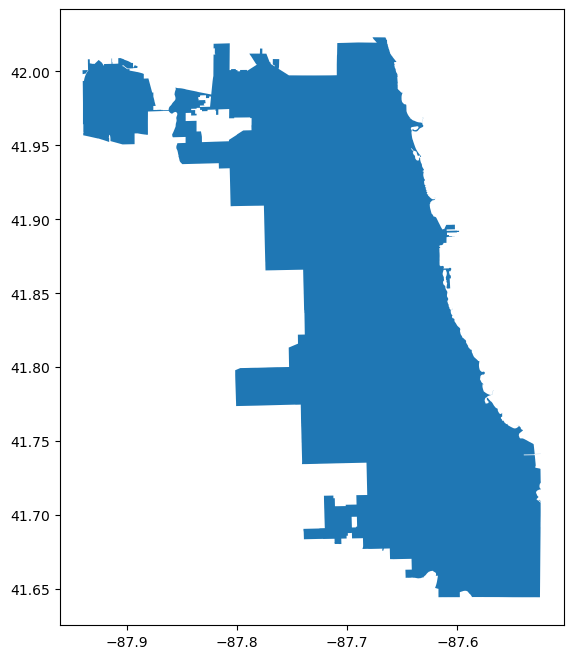

In [2]:
# Load the polygons
polygons = gpd.read_file("./data/original/Chicago_Boundaries.zip")

# Min/Max Longitude/Latitude
print(polygons.total_bounds)

# Show plot
polygons.plot(markersize=.1, figsize=(8, 8))

### Create a basic grid based on boundaries

c:\Users\ejwda\Anaconda3\envs\geo_packages\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


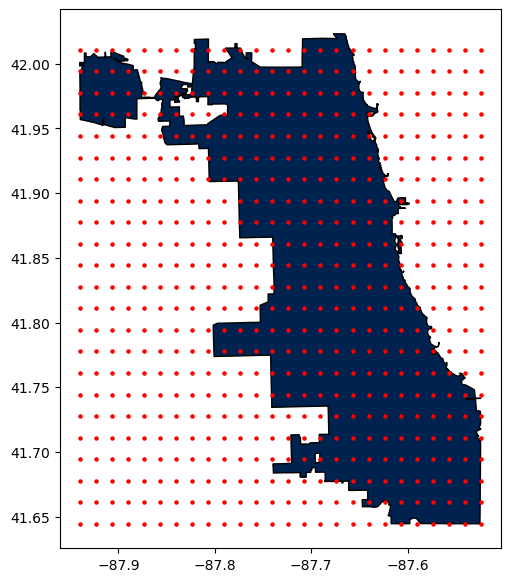

In [3]:
# get boundaries - Chicago is 25 miles north/south and 15 miles east/west. Set interval to be 0.1 miles
xmin, ymin, xmax, ymax = polygons.total_bounds
max_distance = max( abs(xmin-xmax), abs(ymin-ymax))
interval = max_distance/25
yvalues = np.arange(ymin, ymax, interval)
xvalues = np.arange(xmin, xmax, interval)

# Create Grid
points = []

for y in yvalues:
    for x in xvalues:
        points.append((x,y))

# Create points
geometry = [Point(xy) for xy in points]
crs={'init':'epsg:4326'}
geodata = gpd.GeoDataFrame(points, crs=crs, geometry=geometry)

# view plot
fig, ax = plt.subplots(figsize=(7,7))
polygons.plot(ax=ax, facecolor='Grey', edgecolor='k', alpha=1, linewidth=1, cmap='cividis',markersize=.1, figsize=(8, 8))
geodata.plot(ax=ax, color='red', markersize=5);

### Create grid limited to only Chicago city limits

c:\Users\ejwda\Anaconda3\envs\geo_packages\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


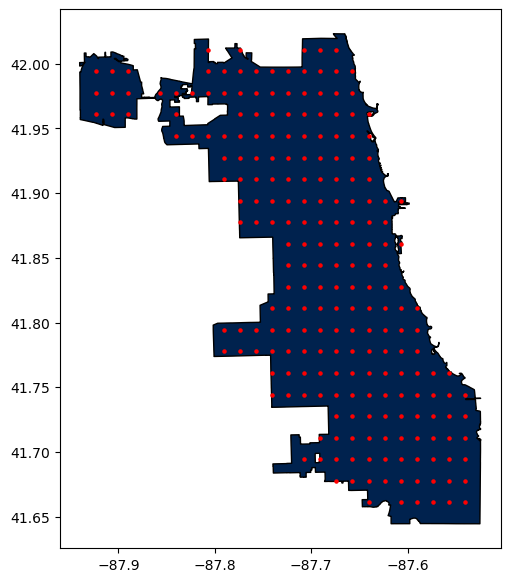

In [4]:
# obtain only the points that exist within the shapefile
chicago_points = []
for xy in points:
    this_point = Point(xy)
    if polygons.contains(this_point)[0]:
        chicago_points.append(xy)

# Create plot of only the Chicago datapoints
fig, ax = plt.subplots(figsize=(7,7))
polygons.plot(ax=ax, facecolor='Grey', edgecolor='k', alpha=1, linewidth=1, cmap='cividis',markersize=.1, figsize=(8, 8))
geometry = [Point(xy) for xy in chicago_points]
geodata = gpd.GeoDataFrame(chicago_points, crs=crs, geometry=geometry)
geodata.plot(ax=ax, color='red', markersize=5);

In [ ]:
# write content to csv
with open('./data/manipulated/chicago_point_grid.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['lat', 'lon', 'geometry'])

    for xy in chicago_points:  
        writer.writerow([xy[0], xy[1], Point(xy)])

### Alternate Method to make grid  
Assuming that collection of points is expensive then finding a method that does not use contains would be best.  
A recursive function would probably work well where a central point could be selected and all surrounding points  
then found until reaching a boundary  

c:\Users\ejwda\Anaconda3\envs\geo_packages\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


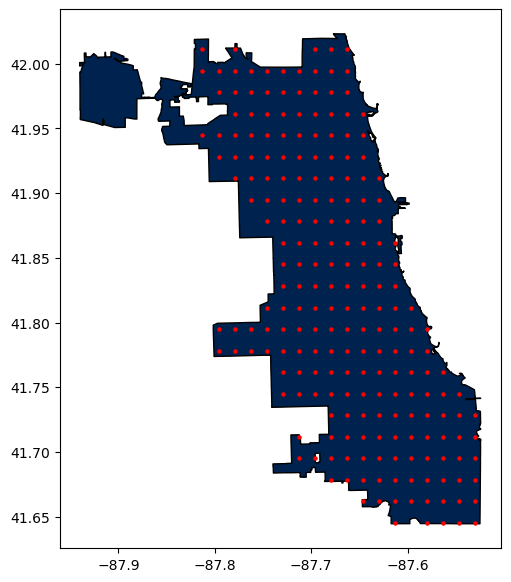

In [7]:
import sys
sys.setrecursionlimit(10000)

polygons = gpd.read_file("./data/original/Chicago_Boundaries.zip")
lon = 41.8781136
lat = -87.6297982
polygons.contains(Point(lat, lon))[0]

# mabe make this a set
def myresults(shp, lat, lon, interval, max):
    points_included = []
    def find_points(shp, lat, lon, interval, max):
        if max == 0:
            pass
        elif (shp.contains(Point(lat, lon))[0]) & ((lat,lon) not in points_included):
            points_included.append((lat, lon))
            find_points(shp, lat+interval, lon, interval, max)
            find_points(shp, lat-interval, lon + interval, interval, max)
        else:
            find_points(shp, lat-interval, lon-interval, interval, max-1)
            # find_points(shp, lat-interval, lon+interval, interval, max-1)

    find_points(shp, lat, lon, interval, max)
    return points_included

# problem setup
polygons = gpd.read_file("./data/original/Chicago_Boundaries.zip")
lon = 41.8781136
lat = -87.6297982
xmin, ymin, xmax, ymax = polygons.total_bounds
max_distance = max( abs(xmin-xmax), abs(ymin-ymax))
interval = max_distance/25

results = myresults(polygons, lat, lon, interval, 20)

fig, ax = plt.subplots(figsize=(7,7))
polygons.plot(ax=ax, facecolor='Grey', edgecolor='k', alpha=1, linewidth=1, cmap='cividis',markersize=.1, figsize=(8, 8))
geometry = [Point(xy) for xy in results]
crs={'init':'epsg:4326'}
geodata = gpd.GeoDataFrame(results, crs=crs, geometry=geometry)
geodata.plot(ax=ax, color='red', markersize=5);

In [ ]:
# I'm sticking with the first option since it will work well enough and is very simple.
# The above method can be improved to work with complicated shapes by making a few adjustments - change search pattern and interval when finding a deadend.
# I might return to this later so I have the code for future projects.